### Reacher-v2 Environment

In [16]:
import gym
import time
import random

In [17]:
env = gym.make("Reacher-v2")
state = env.reset()

In [18]:
env.observation_space


Box(11,)

In [19]:
env.action_space
# [random.choice(env.action_space) for _ in range(10)]

[[-0.05, 0],
 [-0.025, 0],
 [-0.01, 0],
 [0.01, 0],
 [0.025, 0],
 [0.05, 0],
 [0, -0.05],
 [0, -0.025],
 [0, -0.01],
 [0, 0.01],
 [0, 0.025],
 [0, 0.05]]

In [5]:
for _ in range(1000):
    action = random.choice(env.action_space)
    env.step(action)
    env.render()
env.close()

Creating window glfw


### Render images

In [5]:
images = []
for _ in range(10):
    data = env.render(mode='rgb_array', width=256, height=256)
    images.append(data)
#     action = env.action_space.sample()
#     actions = [[0.1, 0], [0,0.1]]
#     action = random.choice(actions)
    action = random.choice(env.action_space)
#     print("Action: ", action)
    env.step(action)
env.close()
print(data.shape)

Creating offscreen glfw
In def step....... True
In def step....... True
In def step....... True
In def step....... True
(256, 256, 3)


In [7]:
len(images)

10

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


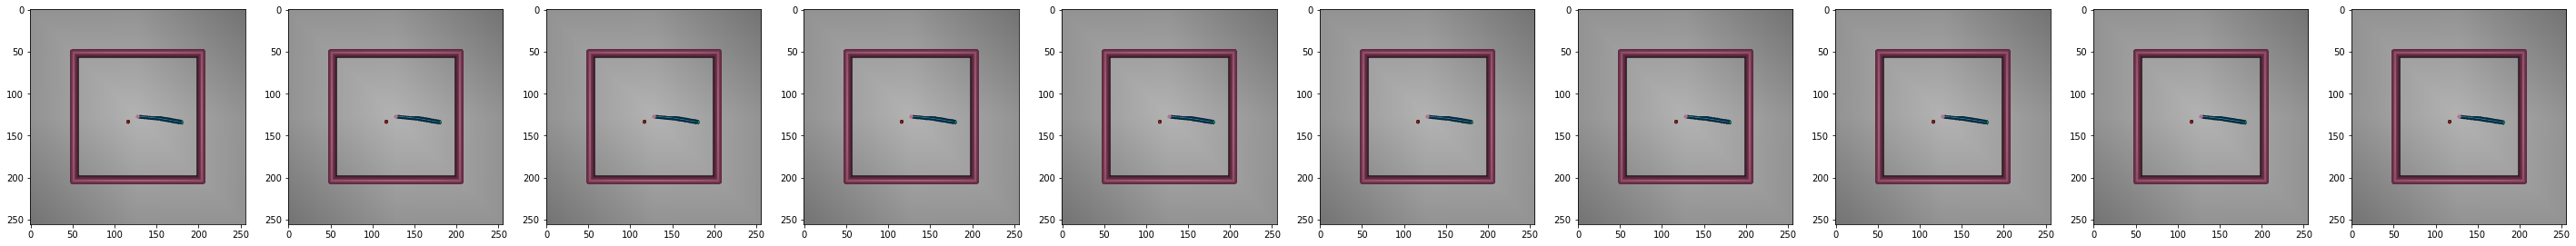

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (50,50))
for i in range(len(images)):
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(images[i])
    print(images[i].shape)
plt.show()
 
# plt.imshow(data, interpolation='nearest')

# w=10
# h=10
# fig=plt.figure(figsize=(8, 8))
# columns = 5
# rows = 2
# for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
# plt.show()

### Densely-connected NN 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                192       
_________________________________________________________________
dense_10 (Dense)             (None, 12)                204       
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                192       
_________________________________________________________________
dense_12 (Dense)             (None, 12)                204       
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________
Pre-trained model doesn't exist.
episode: 0   score: 94.38736862596322  q_value:

episode: 85   score: -1.1075967757827456  q_value: [2.32475864]   memory length: 1744
episode: 86   score: -1.0839647171590874  q_value: [2.32763649]   memory length: 1745
episode: 87   score: 0.9131104037438739  q_value: [2.33187616]   memory length: 1746
episode: 88   score: -1.0800346250713164  q_value: [2.33708108]   memory length: 1747
episode: 89   score: 18.50568393737506  q_value: [2.34174723]   memory length: 1770
episode: 90   score: 0.9468135840839169  q_value: [2.44255793]   memory length: 1771
episode: 91   score: -1.0510088849974781  q_value: [2.44720659]   memory length: 1772
episode: 92   score: -1.0420287872810277  q_value: [2.45356772]   memory length: 1773
episode: 93   score: -1.1007814568601768  q_value: [2.45700856]   memory length: 1774
episode: 94   score: 0.9271338721046345  q_value: [2.4610112]   memory length: 1775
episode: 95   score: -1.0323256440542434  q_value: [2.46775983]   memory length: 1776
episode: 96   score: 94.52784649682498  q_value: [2.47033383

episode: 182   score: 45.602385800021224  q_value: [5.49020337]   memory length: 3434
episode: 183   score: 0.9477394267262766  q_value: [5.53201688]   memory length: 3435
episode: 184   score: 92.35801499225461  q_value: [5.52364702]   memory length: 3535
episode: 185   score: 93.83771181958551  q_value: [5.56379824]   memory length: 3635
episode: 186   score: 73.34174973543634  q_value: [5.62275868]   memory length: 3716
episode: 187   score: -1.0537431153774581  q_value: [5.65379311]   memory length: 3717
episode: 188   score: 0.9255311455027752  q_value: [5.66105464]   memory length: 3718
episode: 189   score: 94.42801161082221  q_value: [5.66571426]   memory length: 3818
episode: 190   score: -2.082148911762701  q_value: [5.70976443]   memory length: 3820
episode: 191   score: 0.910422047037468  q_value: [5.72187766]   memory length: 3821
episode: 192   score: 94.11852125146754  q_value: [5.73256885]   memory length: 3921
episode: 193   score: -2.1621497259270033  q_value: [5.8051

episode: 278   score: 51.975741150210666  q_value: [6.11442265]   memory length: 5257
episode: 279   score: -1.0962229946262045  q_value: [6.09974648]   memory length: 5258
episode: 280   score: -1.017619785681103  q_value: [6.09709737]   memory length: 5259
episode: 281   score: -1.0745546790744498  q_value: [6.1075504]   memory length: 5260
episode: 282   score: 0.9339009264304331  q_value: [6.11331049]   memory length: 5261
episode: 283   score: -1.0702989405843926  q_value: [6.10287899]   memory length: 5262
episode: 284   score: 65.34669931204013  q_value: [6.10749301]   memory length: 5334
episode: 285   score: -1.070933026089094  q_value: [6.06936945]   memory length: 5335
episode: 286   score: -1.0681850613712063  q_value: [6.06120297]   memory length: 5336
episode: 287   score: 0.928839301501992  q_value: [6.0631721]   memory length: 5337
episode: 288   score: 35.42946534769378  q_value: [6.05470589]   memory length: 5377
episode: 289   score: 0.9423196232926393  q_value: [6.0

episode: 374   score: 19.644757313194564  q_value: [6.08402703]   memory length: 6766
episode: 375   score: -1.0619272775873392  q_value: [6.09740346]   memory length: 6767
episode: 376   score: -1.086920243528579  q_value: [6.07955971]   memory length: 6768
episode: 377   score: 0.9345386741332937  q_value: [6.07703863]   memory length: 6769
episode: 378   score: 11.669301926598594  q_value: [6.07845379]   memory length: 6785
episode: 379   score: 0.9310672515148833  q_value: [6.10162694]   memory length: 6786
episode: 380   score: 94.52025105136774  q_value: [6.10809842]   memory length: 6886
episode: 381   score: -2.15947097038565  q_value: [6.06712404]   memory length: 6888
episode: 382   score: -1.084331958988782  q_value: [6.07055845]   memory length: 6889
episode: 383   score: -1.054476005643852  q_value: [6.08080123]   memory length: 6890
episode: 384   score: 0.9218861226816154  q_value: [6.09303547]   memory length: 6891
episode: 385   score: -1.0841274995624766  q_value: [6.

episode: 470   score: 30.61234466058866  q_value: [6.01891236]   memory length: 8319
episode: 471   score: 0.9077827526307237  q_value: [6.03569059]   memory length: 8320
episode: 472   score: -1.0770511932429716  q_value: [6.04313939]   memory length: 8321
episode: 473   score: 48.065374528738765  q_value: [6.03699271]   memory length: 8375
episode: 474   score: 0.9195287250084011  q_value: [6.09071889]   memory length: 8376
episode: 475   score: 89.13720366727696  q_value: [6.09853985]   memory length: 8474
episode: 476   score: -1.0235152913922352  q_value: [6.10180514]   memory length: 8475
episode: 477   score: -1.0302175870916908  q_value: [6.09409471]   memory length: 8476
episode: 478   score: 0.9134245138349387  q_value: [6.08962144]   memory length: 8477
episode: 479   score: 92.68862263694685  q_value: [6.08550186]   memory length: 8577
episode: 480   score: 4.652810073864098  q_value: [5.9588756]   memory length: 8586
episode: 481   score: -1.0952968322293481  q_value: [5.9

episode: 566   score: -1.0411181838206767  q_value: [5.96614951]   memory length: 10021
episode: 567   score: -1.0896389106826738  q_value: [5.96783832]   memory length: 10022
episode: 568   score: 0.9251619024701158  q_value: [5.97522426]   memory length: 10023
episode: 569   score: 85.31967539488217  q_value: [5.98500736]   memory length: 10117
episode: 570   score: -1.0360405527562409  q_value: [5.91964049]   memory length: 10118
episode: 571   score: 0.975383908243629  q_value: [5.92694595]   memory length: 10119
episode: 572   score: -1.018619935924937  q_value: [5.92518525]   memory length: 10120
episode: 573   score: 40.63889829925026  q_value: [5.90830223]   memory length: 10166
episode: 574   score: 0.9423755558136706  q_value: [5.93997555]   memory length: 10167
episode: 575   score: 93.6669430475424  q_value: [5.93392484]   memory length: 10267
episode: 576   score: -2.054980087501667  q_value: [5.95498914]   memory length: 10269
episode: 577   score: -1.0865322747555437  q_

episode: 661   score: -1.059394407375519  q_value: [5.76202047]   memory length: 11751
episode: 662   score: 0.9440603974485958  q_value: [5.76814406]   memory length: 11752
episode: 663   score: 84.14765118138799  q_value: [5.76877067]   memory length: 11845
episode: 664   score: -1.0413053850053555  q_value: [5.72508861]   memory length: 11846
episode: 665   score: -1.0535983460633165  q_value: [5.73398338]   memory length: 11847
episode: 666   score: -1.0307647578490222  q_value: [5.73616392]   memory length: 11848
episode: 667   score: 0.9577002023747113  q_value: [5.74650298]   memory length: 11849
episode: 668   score: 85.67993688159464  q_value: [5.74002879]   memory length: 11944
episode: 669   score: -1.0832272137535002  q_value: [5.79323146]   memory length: 11945
episode: 670   score: -1.039605256817807  q_value: [5.79753369]   memory length: 11946
episode: 671   score: -1.0765309775751117  q_value: [5.80594681]   memory length: 11947
episode: 672   score: -1.050673709355244

episode: 757   score: -1.0950630832762482  q_value: [5.76878176]   memory length: 13388
episode: 758   score: -1.066594671910191  q_value: [5.76836595]   memory length: 13389
episode: 759   score: 0.9310689608870301  q_value: [5.7628992]   memory length: 13390
episode: 760   score: 51.40370814367967  q_value: [5.77310586]   memory length: 13448
episode: 761   score: -1.0483899221150523  q_value: [5.77231643]   memory length: 13449
episode: 762   score: 0.9840525620708277  q_value: [5.783736]   memory length: 13450
episode: 763   score: -1.088841812880065  q_value: [5.7954819]   memory length: 13451
episode: 764   score: -1.0660984246339091  q_value: [5.80470378]   memory length: 13452
episode: 765   score: -1.0485387526933643  q_value: [5.7800166]   memory length: 13453
episode: 766   score: -1.0847293466367713  q_value: [5.78393547]   memory length: 13454
episode: 767   score: 0.9799217776419754  q_value: [5.78543803]   memory length: 13455
episode: 768   score: -1.0474882652621949  q

episode: 852   score: -1.0361520551580419  q_value: [5.92929198]   memory length: 14889
episode: 853   score: -1.006123692678649  q_value: [5.9313804]   memory length: 14890
episode: 854   score: 0.9444609168012965  q_value: [5.93042575]   memory length: 14891
episode: 855   score: 94.90839469248267  q_value: [5.92386252]   memory length: 14991
episode: 856   score: -2.1483226501807033  q_value: [5.88614072]   memory length: 14993
episode: 857   score: 0.9589533090022077  q_value: [5.89322628]   memory length: 14994
episode: 858   score: -1.0686489996616535  q_value: [5.89200336]   memory length: 14995
episode: 859   score: 66.29726954272193  q_value: [5.8814118]   memory length: 15068
episode: 860   score: 0.9856983107859719  q_value: [5.91247402]   memory length: 15069
episode: 861   score: -1.080318796420015  q_value: [5.90556727]   memory length: 15070
episode: 862   score: -1.0272452758632873  q_value: [5.90718909]   memory length: 15071
episode: 863   score: 0.967739163799923  q_

episode: 949   score: 56.629780190499304  q_value: [6.27050702]   memory length: 17295
episode: 950   score: -1.082786128624745  q_value: [6.28824576]   memory length: 17296
episode: 951   score: 0.9412632520058474  q_value: [6.28677131]   memory length: 17297
episode: 952   score: 6.959955549624473  q_value: [6.29063742]   memory length: 17308
episode: 953   score: 0.953297977179133  q_value: [6.27979417]   memory length: 17309
episode: 954   score: -1.0669027301568772  q_value: [6.28507569]   memory length: 17310
episode: 955   score: 68.90435410884012  q_value: [6.28212967]   memory length: 17385
episode: 956   score: 0.9574640507442422  q_value: [6.31396204]   memory length: 17386
episode: 957   score: 46.18553210897373  q_value: [6.29909156]   memory length: 17438
episode: 958   score: 0.9592759841470818  q_value: [6.30027244]   memory length: 17439
episode: 959   score: 56.27479632744757  q_value: [6.30076116]   memory length: 17501
episode: 960   score: -1.0717416474435673  q_va

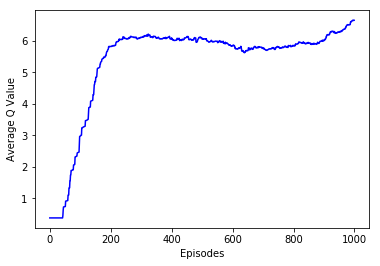

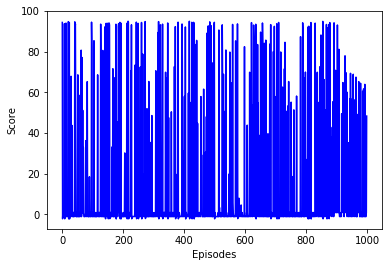

In [3]:
import sys
import gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential, load_model
import os
from IPython.core.debugger import set_trace

EPISODES = 1000#Maximum number of episodes
random.seed(1)  # fix the random seed
#DQN Agent for the reacher-v2
#Q function approximation with NN, experience replay, and target network
class DQNAgent:
    #Constructor for the agent (invoked when DQN is first called in main)
    def __init__(self, state_size, action_space):
        self.check_solve = False	#If True, stop if you satisfy solution condition
        self.render = False #If you want to see Cartpole learning, then change to True
        self.action_space = action_space
        #Get size of state and action
        self.state_size = state_size
        self.action_size = len(action_space)
        

################################################################################
################################################################################
        #Set hyper parameters for the DQN. Do not adjust those labeled as Fixed.
        self.discount_factor = 0.95
        self.learning_rate = 0.005  # 0.005
        self.epsilon = 0.02 #Fixed
        self.batch_size = 32 #Fixed
        self.memory_size = 500000  # 1000
        self.train_start = 1000 #Fixed
        self.target_update_frequency = 1
################################################################################
################################################################################

        #Number of test states for Q value plots
        self.test_state_no =10000 # 10000

        #Create memory buffer using deque
        self.memory = deque(maxlen=self.memory_size)

        #Create main network and target network (using build_model defined below)
        self.model = self.build_model()
        self.target_model = self.build_model()

        #Initialize target network
        self.update_target_model()

    #Approximate Q function using Neural Network
    #State is the input and the Q Values are the output.
###############################################################################
###############################################################################
        #Edit the Neural Network model here
        #Tip: Consult https://keras.io/getting-started/sequential-model-guide/
    def build_model(self):
        model = Sequential()
        model.add(Dense(16, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        opt = SGD(lr=self.learning_rate, decay=1e-6)
        model.compile(loss='mse', optimizer=opt)
#         model.compile(loss='mse', optimizer=(lr=self.learning_rate))
        
       
        #
        # self.model = Sequential()
        # self.model.add(Dense(16, input_shape=(observation_space,), activation="relu"))
        # self.model.add(Dense(16, activation="relu"))
        # self.model.add(Dense(self.action_space, activation="linear"))
        # self.model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
###############################################################################
###############################################################################
    
    #After some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    #Get action from model using epsilon-greedy policy
    def get_action(self, state):
###############################################################################
###############################################################################
        #Insert your e-greedy policy code here
        #Tip 1: Use the random package to generate a random action.
        #Tip 2: Use keras.model.predict() to compute Q-values from the state.
        if np.random.rand() <= self.epsilon:
            ##############################################################
            # try out the self-designed method
            # First train:
#             action_range = [x for x in range(self.action_size)]
#             access = np.array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0])
#             action = np.random.choice(action_range, p=access/sum(access))
            # Second train:
#             q_value = self.model.predict(state)
#             ind =  np.argmax(q_value[0])
#             action = random.choice([ind - 1, ind, ind + 1])
#             if action < 0:
#                 action = 0
#             if action > self.action_size - 1:
#                 action = self.action_size - 1
            ###############################################################
            action =  random.randrange(self.action_size)
#             print("action:", action)
        else:
            q_value = self.model.predict(state)
            action =  np.argmax(q_value[0])
#             print("q_value: ", q_value)
#             print("action: ", action)
        # action = random.randrange(self.action_size)
#         print("Action: ", action)
        return action
###############################################################################
###############################################################################
    #Save sample <s,a,r,s'> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) #Add sample to the end of the list

    #Sample <s,a,r,s'> from replay memory
    def train_model(self):
        if len(self.memory) < self.train_start: #Do not train if not enough memory
            return
        batch_size = min(self.batch_size, len(self.memory)) #Train on at most as many samples as you have in memory
        mini_batch = random.sample(self.memory, batch_size) #Uniformly sample the memory buffer
        #Preallocate network and target network input matrices.
        update_input = np.zeros((batch_size, self.state_size)) #batch_size by state_size two-dimensional array (not matrix!)
        update_target = np.zeros((batch_size, self.state_size)) #Same as above, but used for the target network
        action, reward, done = [], [], [] #Empty arrays that will grow dynamically

        for i in range(self.batch_size):
            update_input[i] = mini_batch[i][0]#Allocate s(i) to the network input array from iteration i in the batch
            action.append(mini_batch[i][1]) #Store a(i)
            reward.append(mini_batch[i][2]) #Store r(i)
            update_target[i] = mini_batch[i][3] #Allocate s'(i) for the target network array from iteration i in the batch
            done.append(mini_batch[i][4])  #Store done(i)

        target = self.model.predict(update_input) #Generate target values for training the inner loop network using the network model
        target_val = self.target_model.predict(update_target) #Generate the target values for training the outer loop target network
        #Q Learning: get maximum Q value at s' from target network
###############################################################################
###############################################################################
        #Insert your Q-learning code here
        #Tip 1: Observe that the Q-values are stored in the variable target
        #Tip 2: What is the Q-value of the action taken at the last state of the episode?
        for i in range(self.batch_size): #For every batch
            # target[i][action[i]] = random.randint(0,1)
            ############################################################### edited by andy
#             action2ind = {(-0.0001, 0):0,(0.0001, 0):1,(0 , -0.0001):2,(0, 0.0001):3}
#             action2ind = {(-0.0001, 0):0, (-0.01, 0):1,(0.0001, 0):2, (0.01, 0):3,(0 , -0.0001):4, (0, -0.01):5,(0, 0.0001):6, (0, 0.01):7}
            
#             action_tuple = tuple(action[i])
#             action_ind = action2ind[action_tuple]
            action_ind = self.action_space.index(action[i])
            if done[i]:
                target[i][action_ind]= reward[i]
            else:
                target[i][action_ind] = reward[i] + self.discount_factor * (
                    np.amax(target_val[i]))
            #################################################################
#             if done[i]:
#                 target[i][action[i]]= reward[i]
#             else:
#                 target[i][action[i]] = reward[i] + self.discount_factor * (
#                     np.amax(target_val[i]))
###############################################################################
###############################################################################

        #Train the inner loop network
        self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)
        return
    
    
    def save_model(self, path_to_model, path_to_target):
            self.model.save(path_to_model)
            self.target_model.save(path_to_target)
            return
        
    def restore_model(self, path_to_model, path_to_target):
            self.model = load_model(path_to_model)
            self.target_model = load_model(path_to_target)
            return
        
    #Plots the score per episode as well as the maximum q value per episode, averaged over precollected states.
    def plot_data(self, episodes, scores, max_q_mean):
        pylab.figure(0)
        pylab.plot(episodes, max_q_mean, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Average Q Value")
        pylab.savefig("qvalues_sgd.png")

        pylab.figure(1)
        pylab.plot(episodes, scores, 'b')
        pylab.xlabel("Episodes")
        pylab.ylabel("Score")
        pylab.savefig("scores_sgd.png")

if __name__ == "__main__":
    
    env = gym.make('Reacher-v2') #Generate Reacher-v2 environment object from the gym library
    #Get state and action sizes from the environment
    state_size = env.observation_space.shape[0]
    action_size = len(env.action_space)
#     action_size = env.action_space.n
    #Create agent, see the DQNAgent __init__ method for details
    agent = DQNAgent(state_size, env.action_space)
    
    #load the pre-trained model
    path_to_model = 'model_sgd.h5'
    path_to_target = 'target_model_sgd.h5'
    if os.path.isfile(path_to_model) and os.path.isfile(path_to_target):
        print("Loading the pre-trained model......")
        agent.restore_model(path_to_model, path_to_target)
    else:
        print("Pre-trained model doesn't exist.")
    

#     #Collect test states for plotting Q values using uniform random policy
    test_states = np.zeros((agent.test_state_no, state_size))
    max_q = np.zeros((EPISODES, agent.test_state_no))
    max_q_mean = np.zeros((EPISODES,1))
    done = True
    for i in range(agent.test_state_no):
        if done:
            done = False
            state = env.reset()
            state = np.reshape(state, [1, state_size])
            test_states[i] = state
        else:
            #############################
#             action = random.randrange(action_size)

            action_idx = random.randrange(action_size)
            action = env.action_space[action_idx]
            ###################################
#             if done:
#                 print("Before Done: ", done)
            next_state, reward, done, info= env.step(action)
#             if done:
#                 print("Done: ", done)
#                 print("Info: ", info)
            next_state = np.reshape(next_state, [1, state_size])
            test_states[i] = state
            state = next_state

    scores, episodes = [], [] #Create dynamically growing score and episode counters
    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset() #Initialize/reset the environment
        state = np.reshape(state, [1, state_size]) #Reshape state so that to a 1 by state_size two-dimensional array ie. [x_1,x_2] to [[x_1,x_2]]
        #Compute Q values for plotting
        tmp = agent.model.predict(test_states)  # tmp.shape = num of test states * num of actions
        max_q[e][:] = np.max(tmp, axis=1)
        max_q_mean[e] = np.mean(max_q[e][:])
#         print("e: ", e)
#         print("tmp: ", tmp.shape)
#         print("test_states: ", test_states.shape)
        
        count = 0 
        while not done:
            
            if agent.render:
                env.render() #Show cartpole animation

            #Get action for the current state and go one step in environment
            ###################################
#             action = agent.get_action(state)
            action_idx = agent.get_action(state)
            action = env.action_space[action_idx]
            ###################################
            next_state, reward, done, _= env.step(action)
            
            next_state = np.reshape(next_state, [1, state_size]) #Reshape next_state similarly to state

            #Save sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            #Training step
            agent.train_model()
            score += reward #Store episodic reward
            state = next_state #Propagate state

            if done:
                #At the end of very episode, update the target network
                if e % agent.target_update_frequency == 0:
                    agent.update_target_model()
                #Plot the play time for every episode
                scores.append(score)
                episodes.append(e)

                print("episode:", e, "  score:", score," q_value:", max_q_mean[e],"  memory length:",
                      len(agent.memory))

                # if the mean of scores of last 100 episodes is bigger than 195
                # stop training
                if agent.check_solve:
                    if np.mean(scores[-min(100, len(scores)):]) >= 195:
                        print("solved after", e-100, "episodes")
                        agent.plot_data(episodes,scores,max_q_mean[:e+1])
                        sys.exit()
    agent.plot_data(episodes,scores,max_q_mean)
    # Save the model
    agent.save_model(path_to_model, path_to_target)
    env.close()


In [1]:
# test the model
import gym
env = gym.make("Reacher-v2")
agent = DQNAgent(state_size, env.action_space)

path_to_model = 'model_adam.h5'
path_to_target = 'target_model_adam.h5'
if os.path.isfile(path_to_model) and os.path.isfile(path_to_target):
    print("Loading the pre-trained model......")
    agent.restore_model(path_to_model, path_to_target)
else:
    print("Pre-trained model doesn't exist.")

n_of_steps = 100
state = env.reset()
state = np.reshape(state, [1, state_size])
for i in range(n_of_steps):
    action_idx = agent.get_action(state)
    action = env.action_space[action_idx]
    env.step(action)
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state
    env.render()
env.close()


NameError: name 'DQNAgent' is not defined